In [1]:
# Import de algumas bibliotecas

!pip install google-colab-selenium
!apt update
!apt upgrade
!pip install langdetect
!pip install selenium
!pip install ipywidgets contractions --quiet
!pip install contractions

import google_colab_selenium as gs
import time
from selenium.webdriver.common.by import By
import pandas as pd
from langdetect import detect, LangDetectException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import os
import contractions
import nltk
from sklearn.manifold import TSNE
import seaborn as sns
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.model_selection import GridSearchCV
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import textwrap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from keras.models import load_model
import joblib
import ipywidgets as widgets
from IPython.display import display
import re
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import save_model
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from keras.regularizers import l2


nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt_tab')




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 20.9 MB/s eta 0:00:00
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
def scraping_letras(genero, num_musicas):
    # Criando listas vazias para armazenas as letras e links das músicas
    letras_musicas = []
    links_musicas = []
    contador = 1
    # Acessando a página por gênero utilizando Selenium
    driver.get(f"https://www.letras.mus.br/mais-acessadas/{genero.lower()}/")
    time.sleep(5)
    print(driver.title)

    # Clicando em alguns botões dentro do site para acessar a página de músicas mais acessadas daquele gênero
    # Esperar e clicar em "Semana"
    for button1 in driver.find_elements(By.TAG_NAME, "button"):
        if button1.text == "Semana":
            print("Cliquei no botao1")
            button1.click()
            break

    # Esperar e clicar em "Sempre"
    for button2 in driver.find_elements(By.CLASS_NAME, "js-tab-period"):
        if button2.text == "Sempre":
            print("Cliquei no botao2")
            button2.click()
            break

    time.sleep(5)

    # Pegando os botões aonde estão os links das músicas
    musicas = driver.find_elements(By.TAG_NAME, "b")


    links = []
    # Para cada link botão encontrado vamos tentar recuperar o link da música
    for musica in musicas:
        try:
            link = musica.find_element(By.XPATH, "..").get_attribute("href")
            if link:
                links.append(link)
        except:
            print("Erro ao extrair link da música.")
    # Para cada link recuperado vamos acessar a página dele e extrair a letra da música
    for link in links:
        try:
            driver.get(link)
            time.sleep(5)
            letra = driver.find_element(By.CLASS_NAME, "lyric-original")
            # Utilizamos somente músicas em inglês
            if letra and detect(letra.text) == "en":
                print(f"Música em inglês encontrada({contador}): {link}")
                letras_musicas.append(letra.text)
                links_musicas.append(link)
                contador += 1

        # Tratamento de erros
        except Exception as e:
            print(f"Houve algum erro: {e}")
        if len(letras_musicas) >= num_musicas:
            break
    # No fim printamos o número de letras encontradas.
    print(f"Quantidade de letras encontradas: {len(letras_musicas)}")

    return letras_musicas, links_musicas

In [ ]:
# Função para aplicar stemming nos dados(foi testada, mas preferimos utilizar lematização)
def aplicar_stemming(texto):
    palavras = nltk.tokenize.word_tokenize(texto)
    palavras_stemmed = [stemmer.stem(p) for p in palavras]
    return ' '.join(palavras_stemmed)

In [2]:


# Aplicando lematizador
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
lemmatizer = WordNetLemmatizer()


def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,  # Adjetivo
        'N': wordnet.NOUN, # Substantivo
        'V': wordnet.VERB, # Verbo
        'R': wordnet.ADV   # Advérbio
    }
    return tag_dict.get(tag, wordnet.NOUN)

# Função de aplicação da lematização, semelhante a do stemming
def aplicar_lemmatization(texto):
    palavras = nltk.tokenize.word_tokenize(texto)
    palavras_lemmatized = [lemmatizer.lemmatize(p, get_wordnet_pos(p)) for p in palavras]
    return ' '.join(palavras_lemmatized)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [ ]:
# Rodando Web Scrapins, OBS: Essa parte demora pra caramba, só rodar para teste
driver = gs.Chrome()
driver.set_page_load_timeout(500)

lista_generos = ["Rock", "Pop", "Hip-Hop-Rap", "Country"]
num_musicas = 500


diretorio_salvar = "letras_salvas"


os.makedirs(diretorio_salvar, exist_ok=True)

for genero in lista_generos:
    nome_arquivo = os.path.join(diretorio_salvar, f"letras_{genero.replace(' ', '_')}.csv")

    # Verifica se o gênero já foi salvo
    if os.path.exists(nome_arquivo):
        print(f"Arquivo para {genero} já existe. Pulando scraping.")
        continue

    print(f"Recuperando letras de {genero}...")

    try:
        letras_musicas, links_musicas = scraping_letras(genero, num_musicas)

        df = pd.DataFrame({
            'Genero': genero,
            'Link': links_musicas,
            'Letra': letras_musicas
        })


        df.to_csv(nome_arquivo, index=False)

        print(f"Salvo {len(letras_musicas)} letras de {genero} com sucesso.")

    except Exception as e:
        print(f"Erro ao recuperar {genero}: {e}")
        continue

driver.quit()

print("\nScraping finalizado.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


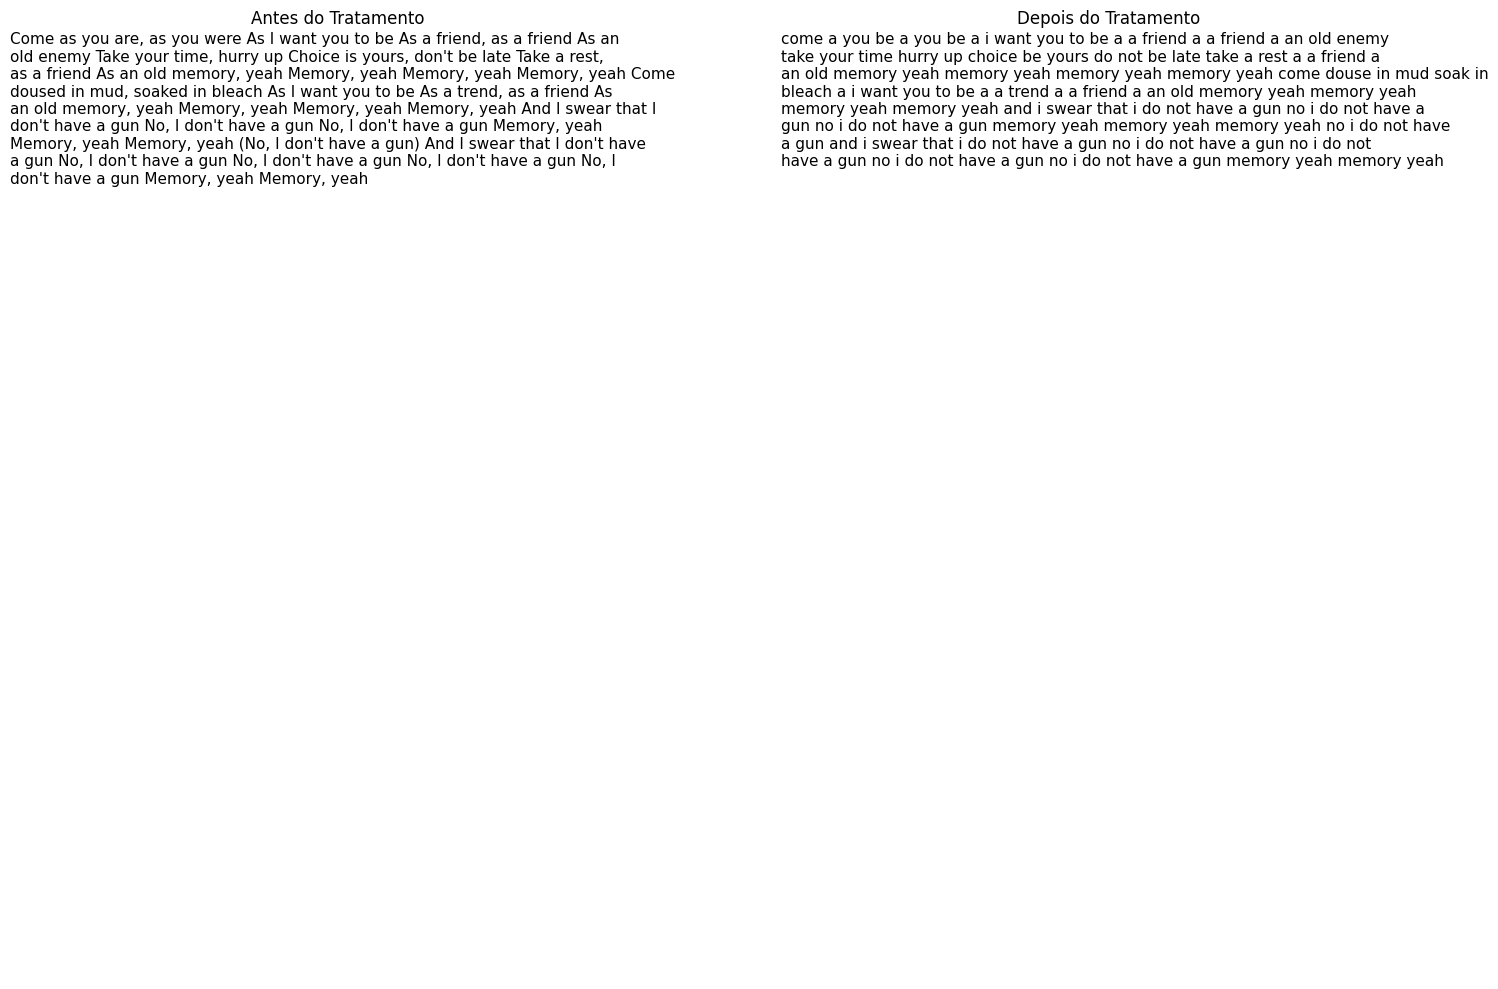

In [66]:





# Tratamento dos dados, removendo stopwords, pontuação e etc.

dataset_Rock = pd.read_csv('letras_Rock_final.csv')
dataset_Pop = pd.read_csv('letras_Pop_final.csv')
dataset_Country = pd.read_csv('letras_Country_final.csv')
dataset_Rap = pd.read_csv('letras_Hip-Hop-Rap_final.csv')

datasetRock500 = dataset_Rock.sample(n=500, random_state=42)
datasetPop500 = dataset_Pop.sample(n=500, random_state=42)
datasetCountry500 = dataset_Country.sample(n=500, random_state=42)
datasetRap500 = dataset_Rap.sample(n=500, random_state=42)

dataset = pd.concat([datasetRock500, datasetPop500, datasetCountry500, datasetRap500], ignore_index=True)

nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt_tab')

stemmer = nltk.stem.RSLPStemmer()
stopwords = nltk.corpus.stopwords.words('english')
letra_antes = dataset.loc[10, 'Letra']
dataset['Letra'] = dataset['Letra'].apply(contractions.fix)
dataset['Letra'] = dataset['Letra'].str.lower()
dataset['Letra'] = dataset['Letra'].str.replace(r'\[.*?\]', '', regex=True)
dataset['Letra'] = dataset['Letra'].str.replace(r'[^\w\s]', '', regex=True)
dataset['Letra'] = dataset['Letra'].str.replace(r'\s+', ' ', regex=True).str.strip()
dataset['Letra'] = dataset['Letra'].apply(aplicar_lemmatization)
letra_depois = dataset.loc[10, 'Letra']


# Aplicando Wrapping na letra, apenas para visualizar melhor
letra_antes_wrapped = "\n".join(textwrap.wrap(letra_antes, width=80))
letra_depois_wrapped = "\n".join(textwrap.wrap(letra_depois, width=80))



plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.title("Antes do Tratamento")
plt.axis('off')
plt.text(0, 1, letra_antes_wrapped, wrap=True, fontsize=11, verticalalignment='top')

plt.subplot(1, 2, 2)
plt.title("Depois do Tratamento")
plt.axis('off')
plt.text(0, 1, letra_depois_wrapped, wrap=True, fontsize=11, verticalalignment='top')

plt.tight_layout()
plt.show()





In [67]:
# Divisão em conjunto de teste e treino para avaliar as métricas dos modelos
X_inicial = dataset["Letra"]
y_inicial = dataset["Genero"]

vectorizer = TfidfVectorizer(stop_words=stopwords, smooth_idf=False)
X = vectorizer.fit_transform(X_inicial)






#pca2 = PCA(n_components=100)
#X_pca = pca2.fit_transform(X.toarray())


X_train, X_test, y_train, y_test = train_test_split(X, y_inicial, stratify=y_inicial, test_size=0.2, random_state=42)

print(f"Conjunto de Treino: {X_train.shape[0]} ")
print(f"Conjunto de Teste: {X_test.shape[0]} ")
print(f"Número de Features: {X_train.shape[1]}")


# Printando o TF-IDF de uma música para exemplificar
feature_names = vectorizer.get_feature_names_out()
vetor = X[10]
vetor_array = vetor.toarray().flatten()


df_vetor = pd.DataFrame({
    "Palavra": feature_names,
    "Valor_TFIDF": vetor_array
})


df_vetor = df_vetor[df_vetor["Valor_TFIDF"] > 0]


df_vetor = df_vetor.sort_values(by="Valor_TFIDF", ascending=False)


print(df_vetor.head(20))

Conjunto de Treino: 1600 
Conjunto de Teste: 400 
Número de Features: 14930
      Palavra  Valor_TFIDF
8260   memory     0.721204
5815      gun     0.487127
14788    yeah     0.333247
5233   friend     0.162700
9224      old     0.126477
4032    douse     0.108962
12880   swear     0.108509
1511   bleach     0.099411
13574   trend     0.099411
12176    soak     0.086785
8692      mud     0.085472
6452    hurry     0.077941
4409    enemy     0.075308
2502   choice     0.074159
10961    rest     0.058132
7466     late     0.051549
2780     come     0.049717
12990    take     0.048868
14314    want     0.045263
13351    time     0.024705


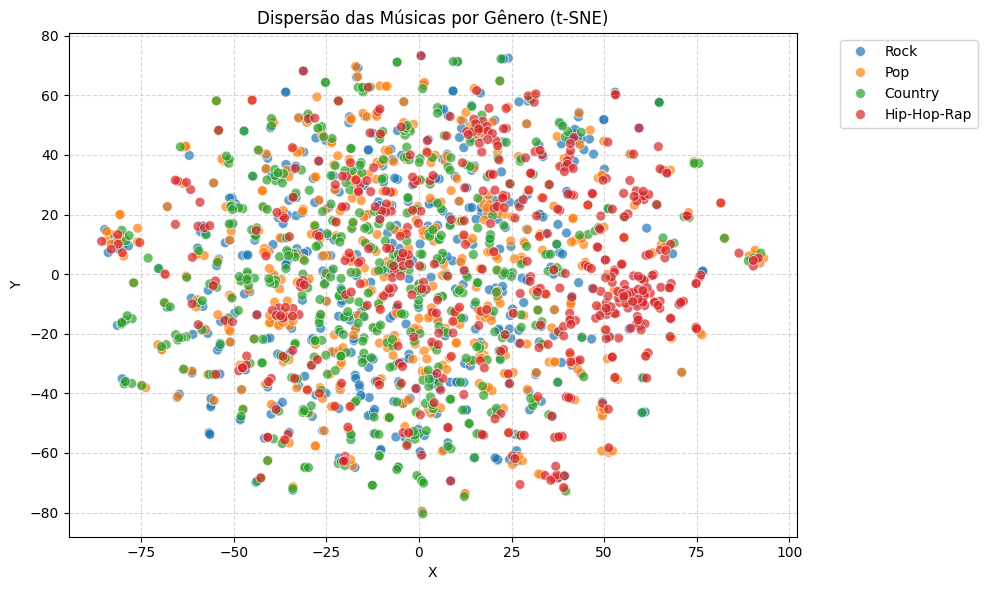

In [ ]:




# Redução de dimensionalidade utilizando TSNE para plotagem(tenta manter a distancia local)
tsne1 = TSNE(n_components=2, perplexity=10, learning_rate=200, random_state=42)
X_tsne = tsne1.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=dataset["Genero"], palette='tab10', s=50, alpha=0.7)
plt.title("Dispersão das Músicas por Gênero (t-SNE)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

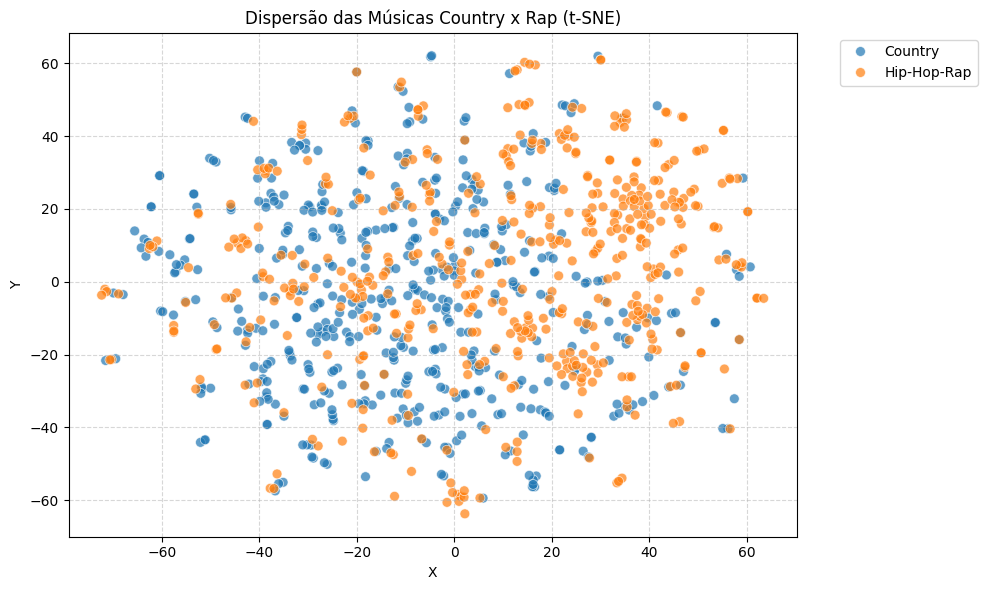

In [ ]:
generos = ['Hip-Hop-Rap', 'Country']


filtragem = dataset[dataset['Genero'].isin(generos)]
X_plotagem_countryxrap = filtragem['Letra'].values

vectorizer2 = TfidfVectorizer(stop_words=stopwords, smooth_idf=False)
X_countryxrap = vectorizer2.fit_transform(X_plotagem_countryxrap)







tsne2 = TSNE(n_components=2, perplexity=10, learning_rate=200, random_state=42)
X_tsne = tsne2.fit_transform(X_countryxrap.toarray())


plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=filtragem["Genero"], palette='tab10', s=50, alpha=0.7)
plt.title("Dispersão das Músicas Country x Rap (t-SNE)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

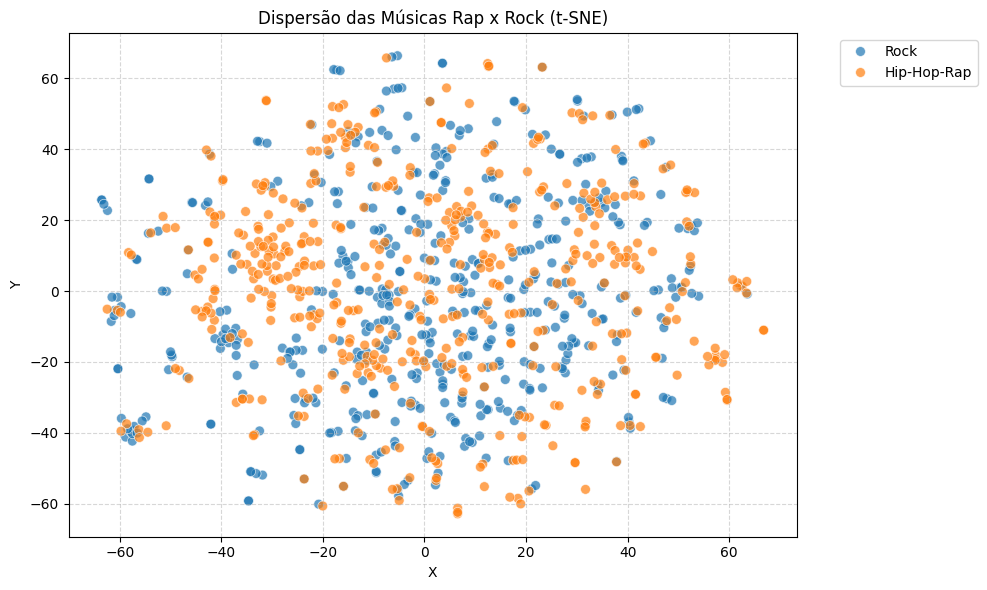

In [ ]:
generos = ['Hip-Hop-Rap', 'Rock']


filtragem = dataset[dataset['Genero'].isin(generos)]
X_plotagem_countryxrap = filtragem['Letra'].values

vectorizer3 = TfidfVectorizer(stop_words=stopwords, smooth_idf=False)
X_countryxrap = vectorizer3.fit_transform(X_plotagem_countryxrap)







tsne3 = TSNE(n_components=2, perplexity=10, learning_rate=200, random_state=42)
X_tsne = tsne3.fit_transform(X_countryxrap.toarray())


plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=filtragem["Genero"], palette='tab10', s=50, alpha=0.7)
plt.title("Dispersão das Músicas Rap x Rock (t-SNE)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

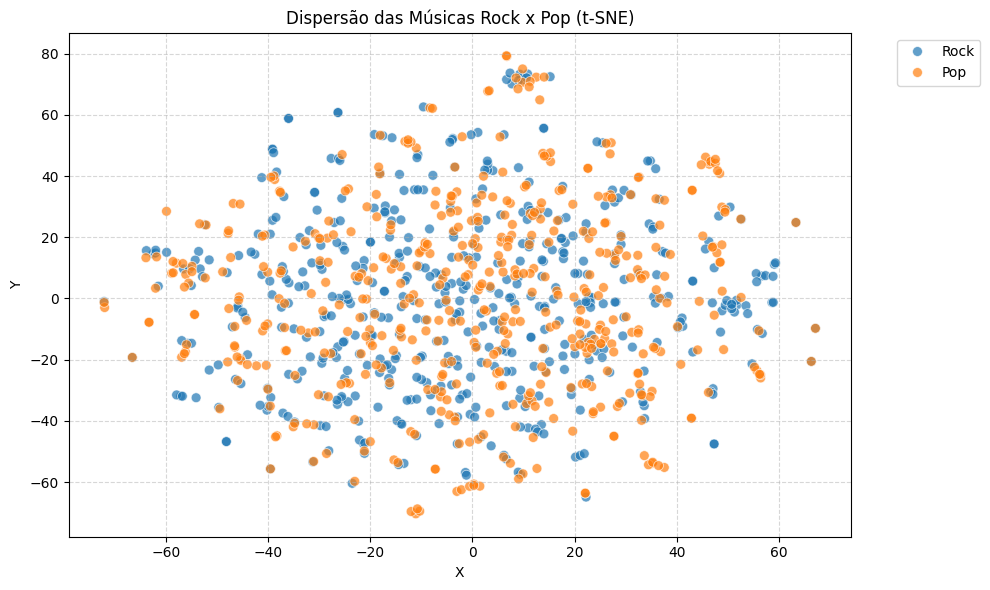

In [ ]:
generos = ['Pop', 'Rock']


filtragem = dataset[dataset['Genero'].isin(generos)]
X_plotagem_countryxrap = filtragem['Letra'].values

vectorizer4 = TfidfVectorizer(stop_words=stopwords, smooth_idf=False)
X_countryxrap = vectorizer4.fit_transform(X_plotagem_countryxrap)







tsne4 = TSNE(n_components=2, perplexity=10, learning_rate=200, random_state=42)
X_tsne = tsne4.fit_transform(X_countryxrap.toarray())


plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=filtragem["Genero"], palette='tab10', s=50, alpha=0.7)
plt.title("Dispersão das Músicas Rock x Pop (t-SNE)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Utilizando SVM(Máquina de Vetores de Suporte) para fazer a classificação.

# Aplicando validação cruzada para encontrar os melhores hiperparametros para o modelo, de modo a obter a melhor acurácia.
grid = GridSearchCV(
    SVC(kernel='rbf'),
    param_grid={'C': [0.001, 0.025, 0.01, 0.0125, 0.1, 1], 'gamma': [0.001, 0.025, 0.01, 0.1, 1, 10]},
    cv=5,
    scoring='accuracy'
)



grid.fit(X_train, y_train)

print("Melhores parâmetros:", grid.best_params_)

y_pred = grid.predict(X_test)


svm_best = grid.best_estimator_
Ein = 1 - svm_best.score(X_train, y_train)
Eout = 1 - svm_best.score(X_test, y_test)
Eout_esperado = len(svm_best.support_) / X_train.shape[0]


print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

print(f"Ein: {Ein}")
print(f"Eout: {Eout}")
print(f"E-out-esperado: {Eout_esperado}")



Melhores parâmetros: {'C': 1, 'gamma': 1}
Acurácia: 0.5475
              precision    recall  f1-score   support

     Country       0.57      0.58      0.58       100
 Hip-Hop-Rap       0.83      0.62      0.71       100
         Pop       0.42      0.41      0.41       100
        Rock       0.46      0.58      0.51       100

    accuracy                           0.55       400
   macro avg       0.57      0.55      0.55       400
weighted avg       0.57      0.55      0.55       400

Ein: 0.018124999999999947
Eout: 0.4525
E-out-esperado: 0.9825


Melhor alpha encontrado: 0.01229238529595611
Erro no treino (Ein): 0.4706
Erro no teste (Eout): 0.4725

Acurácia no treino: 0.5294
Acurácia no teste: 0.5275

Relatório de classificação (treino):
              precision    recall  f1-score   support

     Country       0.60      0.30      0.40       400
 Hip-Hop-Rap       0.80      0.79      0.79       400
         Pop       0.42      0.34      0.38       400
        Rock       0.40      0.69      0.51       400

    accuracy                           0.53      1600
   macro avg       0.55      0.53      0.52      1600
weighted avg       0.55      0.53      0.52      1600


Relatório de classificação (teste):
              precision    recall  f1-score   support

     Country       0.53      0.29      0.37       100
 Hip-Hop-Rap       0.81      0.75      0.78       100
         Pop       0.47      0.38      0.42       100
        Rock       0.40      0.69      0.51       100

    accuracy                           0.53       400
   macr

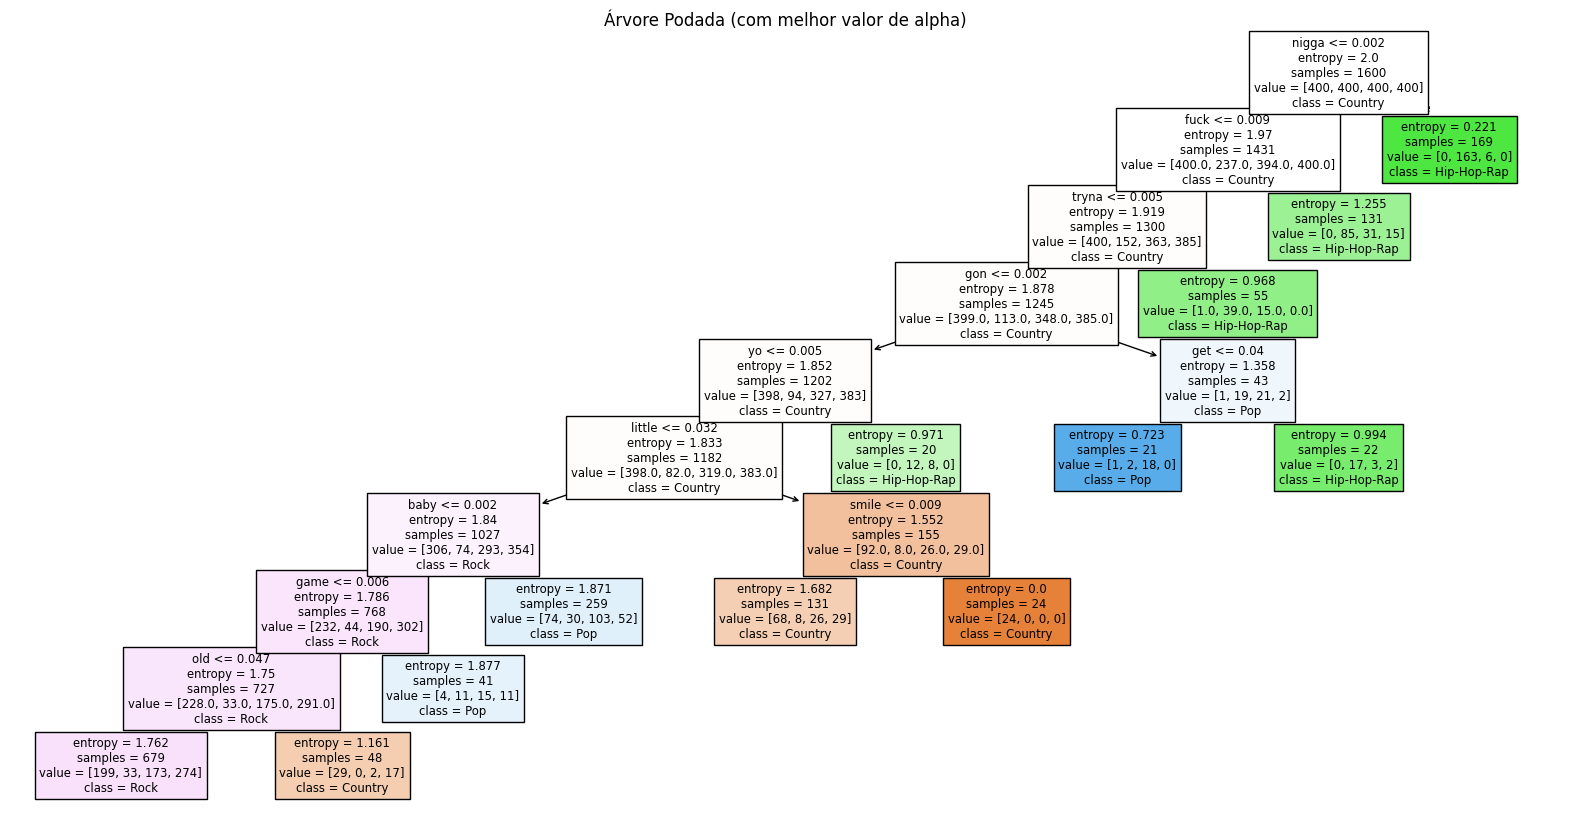

In [ ]:


# Modelo de Árvore de Decisão.

arvore_inicial = DecisionTreeClassifier(random_state=42, criterion='entropy')
arvore_inicial.fit(X_train, y_train)


caminho_poda = arvore_inicial.cost_complexity_pruning_path(X_train, y_train)
cp_alphas = caminho_poda.ccp_alphas


score = []
arvores = []

# Utilizamos regularização para podar a árvore e obter uma melhor generalização.
for alpha in cp_alphas:
    arvore_alpha = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha, criterion='entropy')
    arvore_alpha.fit(X_train, y_train)
    arvores.append(arvore_alpha)
    cv_scores = cross_val_score(arvore_alpha, X_train, y_train, cv=5)
    score.append(cv_scores.mean())


melhor_alpha = cp_alphas[np.argmax(score)]
print(f"Melhor alpha encontrado: {melhor_alpha}")


melhor_arvore = DecisionTreeClassifier(random_state=42, ccp_alpha=melhor_alpha, criterion='entropy')
melhor_arvore.fit(X_train, y_train)


y_train_pred = melhor_arvore.predict(X_train)
y_test_pred = melhor_arvore.predict(X_test)

Ein = 1 - accuracy_score(y_train, y_train_pred)
Eout = 1 - accuracy_score(y_test, y_test_pred)

print(f"Erro no treino (Ein): {Ein:.4f}")
print(f"Erro no teste (Eout): {Eout:.4f}")


print(f"\nAcurácia no treino: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Acurácia no teste: {accuracy_score(y_test, y_test_pred):.4f}")


print("\nRelatório de classificação (treino):")
print(classification_report(y_train, y_train_pred))

print("\nRelatório de classificação (teste):")
print(classification_report(y_test, y_test_pred))

print("Profundidade real da árvore:", melhor_arvore.get_depth())
print("Número de folhas:", melhor_arvore.get_n_leaves())


plt.figure(figsize=(20,10))
plot_tree(melhor_arvore, filled=True,
          feature_names=vectorizer.get_feature_names_out(),
          class_names=melhor_arvore.classes_)
plt.title("Árvore Podada (com melhor valor de alpha)")
plt.show()


In [ ]:
# Tentando fazer funcionar com Rede Neural (Não funcionou legal para os vetores TF-IDF e a quantidade de dados: Muitos atributos, poucos dados)

codificador = LabelBinarizer()
y_codificado = codificador.fit_transform(y_train)
y_codificado_teste = codificador.transform(y_test)



entrada_dimensao = X_train.shape[1]
n_classes = y_codificado.shape[1]
taxa_aprendizado = 0.1


def criar_modelo():
    modelo = Sequential()
    modelo.add(Dense(8, input_dim=entrada_dimensao, activation='relu', kernel_regularizer=l2(0.001)))
    modelo.add(Dense(4, activation='relu'))
    modelo.add(Dense(n_classes, activation='softmax'))
    modelo.compile(optimizer=SGD(learning_rate=taxa_aprendizado),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
    return modelo

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

acuracias = []
melhor_acuracia = 0
melhor_modelo = None

for indice_fold, (indice_treino, indice_validacao) in enumerate(kfold.split(X_train)):
    print(f"\nTreinando Fold {indice_fold + 1}")

    X_treino, X_validacao = X_train[indice_treino], X_train[indice_validacao]
    y_treino, y_validacao = y_codificado[indice_treino], y_codificado[indice_validacao]

    modelo = criar_modelo()

    modelo.fit(X_treino, y_treino,
               validation_data=(X_validacao, y_validacao),
               epochs=30,
               batch_size=32,
               verbose=2)

    perda_validacao, acuracia_validacao = modelo.evaluate(X_validacao, y_validacao, verbose=0)
    print(f"Acurácia no Fold {indice_fold + 1}: {acuracia_validacao:.4f}")
    acuracias.append(acuracia_validacao)


    if acuracia_validacao > melhor_acuracia:
        melhor_acuracia = acuracia_validacao
        melhor_modelo = modelo


print(f"\nAcurácia média após validação cruzada: {np.mean(acuracias):.4f}")
print(f"Melhor acurácia de validação obtida: {melhor_acuracia:.4f}")


melhor_modelo.save('melhor_rede_validacao.keras')
print("Melhor modelo salvo como 'melhor_rede_validacao.keras.")


Treinando Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
40/40 - 2s - 38ms/step - accuracy: 0.2469 - loss: 1.4032 - val_accuracy: 0.2313 - val_loss: 1.4024
Epoch 2/30
40/40 - 1s - 20ms/step - accuracy: 0.2289 - loss: 1.4028 - val_accuracy: 0.2313 - val_loss: 1.4027
Epoch 3/30
40/40 - 0s - 11ms/step - accuracy: 0.2531 - loss: 1.4025 - val_accuracy: 0.2313 - val_loss: 1.4028
Epoch 4/30
40/40 - 1s - 15ms/step - accuracy: 0.2578 - loss: 1.4020 - val_accuracy: 0.2562 - val_loss: 1.4024
Epoch 5/30
40/40 - 0s - 12ms/step - accuracy: 0.2258 - loss: 1.4020 - val_accuracy: 0.2625 - val_loss: 1.4012
Epoch 6/30
40/40 - 1s - 20ms/step - accuracy: 0.2656 - loss: 1.4004 - val_accuracy: 0.2406 - val_loss: 1.4014
Epoch 7/30
40/40 - 1s - 15ms/step - accuracy: 0.2586 - loss: 1.3986 - val_accuracy: 0.2781 - val_loss: 1.4009
Epoch 8/30
40/40 - 1s - 16ms/step - accuracy: 0.2812 - loss: 1.3981 - val_accuracy: 0.2313 - val_loss: 1.4004
Epoch 9/30
40/40 - 1s - 17ms/step - accuracy: 0.2969 - loss: 1.3959 - val_accuracy: 0.2688 - val_loss: 1.4002
Epoch 10/3

In [ ]:





model = load_model('melhor_rede_validacao.keras')

perda, acuracia = model.evaluate(X_test, y_codificado_teste, verbose=1)

print(f"Loss no teste: {perda}")
print(f"Acurácia no teste: {acuracia}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4805 - loss: 1.3196  
Loss no teste: 1.2918394804000854
Acurácia no teste: 0.4925000071525574


In [42]:
novo_dataset = pd.read_csv('train.csv', engine='python', on_bad_lines='skip')




In [43]:
print(novo_dataset['Genre'].value_counts())

Genre
Rock          121404
Pop           108714
Metal          20291
Jazz           13545
Folk            8644
Indie           8449
R&B             2793
Hip-Hop         2240
Electronic      2213
Country         1890
Name: count, dtype: int64


In [56]:

novo_dataset_en = novo_dataset[novo_dataset['Language'] == 'en']


generos_desejados = ['Metal', 'Jazz', 'Rock']


novo_dataset_filtrado = novo_dataset_en[novo_dataset_en['Genre'].isin(generos_desejados)]




novo_dataset_2000 = novo_dataset_filtrado.groupby('Genre').apply(lambda x: x.sample(n=10000, random_state=42)).reset_index(drop=True)


dataset_novo_final = novo_dataset_2000[['Lyrics', 'Genre']]



print(dataset_novo_final.head())

                                              Lyrics Genre
0  She's come undun\nShe didn't know what she was...  Jazz
1  Creole babies walk along with rhythm in their ...  Jazz
2  I wanna go outside in the rain\nIt may sound c...  Jazz
3  I should care; I should go around weeping\nI s...  Jazz
4  Where do they go, the smoke rings I blow each ...  Jazz


<ipython-input-56-426546b7444c>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  novo_dataset_2000 = novo_dataset_filtrado.groupby('Genre').apply(lambda x: x.sample(n=10000, random_state=42)).reset_index(drop=True)


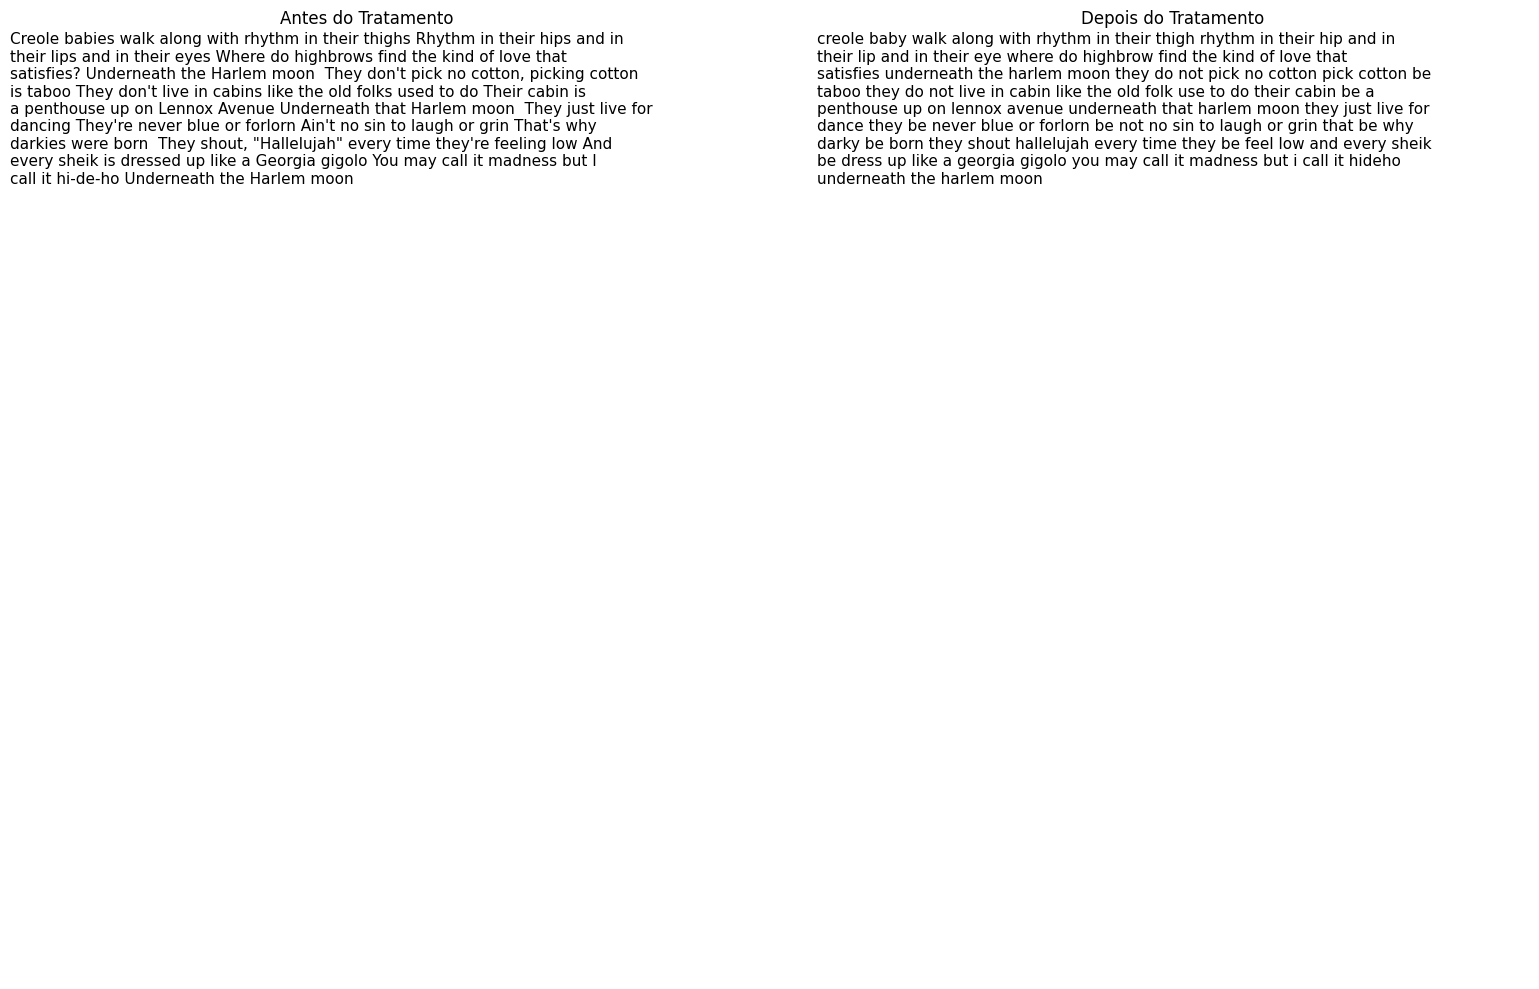

In [57]:

dataset_novo_final = dataset_novo_final.copy()



letra_antes = dataset_novo_final.loc[1, 'Lyrics']
dataset_novo_final['Lyrics'] = dataset_novo_final['Lyrics'].apply(contractions.fix)
dataset_novo_final['Lyrics'] = dataset_novo_final['Lyrics'].str.lower()
dataset_novo_final['Lyrics'] = dataset_novo_final['Lyrics'].str.replace(r'\[.*?\]', '', regex=True)
dataset_novo_final['Lyrics'] = dataset_novo_final['Lyrics'].str.replace(r'[^\w\s]', '', regex=True)
dataset_novo_final['Lyrics'] = dataset_novo_final['Lyrics'].str.replace(r'\s+', ' ', regex=True).str.strip()
dataset_novo_final['Lyrics'] = dataset_novo_final['Lyrics'].apply(aplicar_lemmatization)
letra_depois = dataset_novo_final.loc[1, 'Lyrics']





# Aplicando Wrapping na letra, apenas para visualizar melhor
letra_antes_wrapped = "\n".join(textwrap.wrap(letra_antes, width=80))
letra_depois_wrapped = "\n".join(textwrap.wrap(letra_depois, width=80))


plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.title("Antes do Tratamento")
plt.axis('off')
plt.text(0, 1, letra_antes_wrapped, fontsize=11, verticalalignment='top')

plt.subplot(1, 2, 2)
plt.title("Depois do Tratamento")
plt.axis('off')
plt.text(0, 1, letra_depois_wrapped, fontsize=11, verticalalignment='top')

plt.tight_layout()
plt.show()

In [58]:
# Divisão em conjunto de teste e treino para avaliar as métricas dos modelos
X_novo = dataset_novo_final["Lyrics"]
y_novo = dataset_novo_final["Genre"]

# Utilizando as mesmas funções aplicadas em sala para tokenizar as letras e criar sequências
def split_tokens(row):
    row = word_tokenize(row)
    return row

X_novo = X_novo.apply(split_tokens)

all_tokens = []

for tokens in X_novo:
  all_tokens.extend(tokens)


len(all_tokens)


6158267

In [59]:
from collections import Counter
counts = Counter(all_tokens)

vocab = [token for token, count in counts.items() if count >= 5]

vocab = ['<unk>'] + vocab

print(len(vocab))

vocab[10]

X_novo.head(5)

15428


,Lyrics
0,"[she, be, come, undun, she, do, not, know, wha..."
1,"[creole, baby, walk, along, with, rhythm, in, ..."
2,"[i, want, to, go, outside, in, the, rain, it, ..."
3,"[i, should, care, i, should, go, around, weep,..."
4,"[where, do, they, go, the, smoke, ring, i, blo..."


In [60]:
token2id = {token: idx for idx, token in enumerate(vocab)}



def convert_tokens(tokens):
  result = []
  for token in tokens:
    result.append(token2id.get(token, 0))

  return result

X_novo = X_novo.apply(convert_tokens)

X_novo.head(5)





,Lyrics
0,"[1, 2, 3, 4, 1, 5, 6, 7, 8, 1, 2, 9, 10, 11, 1..."
1,"[50, 51, 52, 53, 54, 55, 56, 57, 58, 55, 56, 5..."
2,"[13, 30, 37, 26, 110, 56, 28, 111, 15, 107, 11..."
3,"[13, 123, 124, 13, 123, 26, 125, 126, 13, 123,..."
4,"[61, 5, 71, 26, 28, 147, 148, 13, 149, 150, 15..."


494

In [61]:









#pca2 = PCA(n_components=100)
#X_pca = pca2.fit_transform(X.toarray())


X_train, X_test, y_train, y_test = train_test_split(X_novo, y_novo, stratify=y_novo, test_size=0.2, random_state=42)

print(f"Conjunto de Treino: {len(X_train)} ")
print(f"Conjunto de Teste: {len(X_test)} ")





Conjunto de Treino: 24000 
Conjunto de Teste: 6000 


In [63]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 300

X_train_pad = pad_sequences(X_train, maxlen=max_len, padding='post', value=token2id['<unk>'])
X_test_pad = pad_sequences(X_test, maxlen=max_len, padding='post', value=token2id['<unk>'])


In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping



# Codifica as classes
label_encoder = LabelEncoder()
y_train_enc = to_categorical(label_encoder.fit_transform(y_train))
y_test_enc = to_categorical(label_encoder.transform(y_test))

# Parâmetros do modelo
vocab_size = len(vocab)
embedding_dim = 128
n_classes = y_train_enc.shape[1]
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Modelo
modelo = Sequential()
modelo.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
modelo.add(LSTM(128, recurrent_dropout=0.5))
modelo.add(Dropout(0.5))
modelo.add(Dense(n_classes, activation='softmax', kernel_regularizer=l2(0.001)))

modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

modelo.fit(X_train_pad, y_train_enc, validation_data=(X_test_pad, y_test_enc), epochs=10, batch_size=32, callbacks=[early_stop])

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 594s 788ms/step - accuracy: 0.3662 - loss: 1.0959 - val_accuracy: 0.3907 - val_loss: 1.0807
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 584s 779ms/step - accuracy: 0.3996 - loss: 1.0719 - val_accuracy: 0.3947 - val_loss: 1.0753
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 618s 774ms/step - accuracy: 0.4074 - loss: 1.0584 - val_accuracy: 0.5503 - val_loss: 0.9535
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 619s 770ms/step - accuracy: 0.5765 - loss: 0.9106 - val_accuracy: 0.6148 - val_loss: 0.8350
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 606s 748ms/step - accuracy: 0.6457 - loss: 0.7980 - val_accuracy: 0.6583 - val_loss: 0.7705
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 558s 744ms/step - accuracy: 0.7088 - loss: 0.7017 - val_accuracy: 0.6922 - val_loss: 0.7251
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 566s 750ms/step - accuracy: 0.7570 - loss: 0.6164 - val_accuracy: 0.7055 - val_loss: 0.7173
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 640s 774ms/step - accuracy: 0.7953 -

In [65]:
y_pred_probs = modelo.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_enc, axis=1)

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step
              precision    recall  f1-score   support

        Jazz       0.80      0.76      0.78      2000
       Metal       0.72      0.78      0.75      2000
        Rock       0.59      0.58      0.59      2000

    accuracy                           0.71      6000
   macro avg       0.71      0.71      0.71      6000
weighted avg       0.71      0.71      0.71      6000



In [ ]:
import joblib

# Salvando modelo pra criar a interface
joblib.dump(modelo, 'modelo_genero_musical.joblib')
joblib.dump(vectorizer, 'vetorizer_tfidf.joblib')

['vetorizer_tfidf.joblib']

In [ ]:



# Carregando o modelo e o vectorizer
modelo = joblib.load('modelo_genero_musical.joblib')
vectorizer = joblib.load('vetorizer_tfidf.joblib')





# Mesmo tratamento de lá de cima
def tratar_letra(texto):
    texto = contractions.fix(texto)
    texto = texto.lower()
    texto = re.sub(r'\[.*?\]', '', texto)
    texto = re.sub(r'[^\w\s]', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    texto = aplicar_lemmatization(texto)
    return texto

# Pequena interface só para mostrar o modelo tentando classificar as letras.
entrada_letra = widgets.Textarea(
    value='',
    placeholder='Digite a letra da música:',
    description='Letra:',
    layout=widgets.Layout(width='90%', height='200px')
)

botao = widgets.Button(description="Classificar Letra")
saida = widgets.Output()

def classificar_letra(b):
    letra = entrada_letra.value
    letra_tratada = tratar_letra(letra)
    X = vectorizer.transform([letra_tratada])
    predicao = modelo.predict(X)

    with saida:
        saida.clear_output()
        print(f"🎵 Gênero previsto: {predicao[0]}")

botao.on_click(classificar_letra)
display(entrada_letra, botao, saida)


🎵 Gênero previsto: Hip-Hop-Rap
